/tmp/ipython-input-1412486947.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


CV accuracy (mean±sd): 0.796 ± 0.015
Class weights: {0: 1.0, 1: 2.768561872909699}
Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6920 - loss: 0.8760 - val_accuracy: 0.6770 - val_loss: 0.5637
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7237 - loss: 0.7774 - val_accuracy: 0.6992 - val_loss: 0.5501
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7403 - loss: 0.7265 - val_accuracy: 0.6965 - val_loss: 0.5500
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7519 - loss: 0.7366 - val_accuracy: 0.7081 - val_loss: 0.5279
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7402 - loss: 0.7436 - val_accuracy: 0.7090 - val_loss: 0.5369
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7533 - loss: 0.7270 - val_accuracy: 0.7072 - val_loss: 0.5420
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7645 - loss: 0.6904 - val_accuracy: 0.7072 - val_loss: 0.5476

Best profit threshol

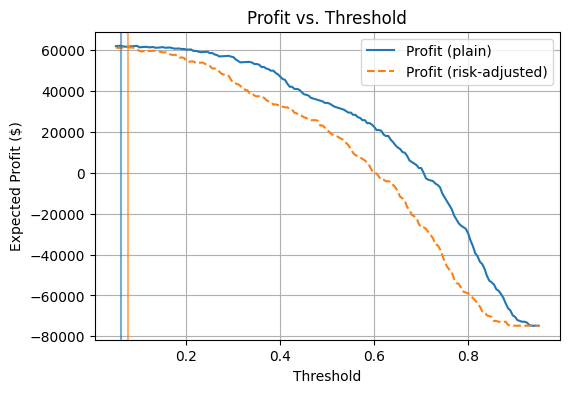


Top 15 high-risk customers (risk-adjusted):


,pred_prob_mean,pred_uncertainty,risk_adjusted_score,true_label
0,0.929793,0.042345,0.887448,1
1,0.924953,0.040402,0.884552,1
2,0.929969,0.045532,0.884437,1
3,0.927235,0.045189,0.882046,1
4,0.934877,0.054247,0.880630,1
5,0.925295,0.044829,0.880466,0
6,0.913486,0.053465,0.860020,1
7,0.904424,0.049872,0.854552,0
8,0.895771,0.042649,0.853122,1
9,0.903602,0.050631,0.852971,1


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------------
# 1) Load & preprocess (URL)
# -----------------------------
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

df.drop("customerID", axis=1, inplace=True)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

scaler = StandardScaler()
X = scaler.fit_transform(df.drop("Churn", axis=1))
y = df["Churn"].values

# -----------------------------
# 2) Model builder (Dropout kept for MC inference)
# -----------------------------
def build_model(dropout=0.3):
    m = keras.Sequential([
        layers.Input(shape=(X.shape[1],)),
        layers.Dense(128), layers.BatchNormalization(), layers.ReLU(),
        layers.Dropout(dropout),
        layers.Dense(64),  layers.BatchNormalization(), layers.ReLU(),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid"),
    ])
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m

# -----------------------------
# 3) Cross-validation for sanity
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = []
for f,(tr,va) in enumerate(skf.split(X,y),1):
    m = build_model()
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    m.fit(X[tr],y[tr], validation_data=(X[va],y[va]), epochs=15, batch_size=32, verbose=0, callbacks=[es])
    cv_acc.append(m.evaluate(X[va],y[va], verbose=0)[1])
print(f"CV accuracy (mean±sd): {np.mean(cv_acc):.3f} ± {np.std(cv_acc):.3f}")

# -----------------------------
# 4) Final split + class weights
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
cnt = Counter(y_train); cw = {0:1.0, 1: cnt[0]/cnt[1]}  # weight minority
print("Class weights:", cw)

model = build_model()
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32,
          class_weight=cw, callbacks=[es], verbose=1)

# -----------------------------
# 5) Uncertainty via MC Dropout
# -----------------------------
mc_model = build_model()
mc_model.set_weights(model.get_weights())

def mc_predict(mod, x, n_iter=50):
    preds = [mod(x, training=True).numpy().ravel() for _ in range(n_iter)]
    preds = np.vstack(preds)              # [n_iter, n_samples]
    return preds.mean(axis=0), preds.std(axis=0)

p_mean, p_std = mc_predict(mc_model, X_test, n_iter=50)

# -----------------------------
# 6) Profit-optimal threshold
#    Set business costs here:
#    - cost_fn: missed churn (lost revenue)
#    - cost_fp: contacting/offer cost to a non-churner
# -----------------------------
cost_fn = 200.0   # $ loss if churner not targeted
cost_fp = 10.0    # $ cost to target a non-churner
# If we target a churner (TP), assume cost_fp is spent but churn is prevented (benefit = cost_fn)
# Net TP benefit = cost_fn - cost_fp

def profit_at_threshold(t):
    y_hat = (p_mean >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    profit = tp*(cost_fn - cost_fp) - fp*cost_fp - fn*cost_fn  # TN assumed ~0
    return profit, (tn, fp, fn, tp)

# Risk-adjusted variant (penalize uncertain positives): use mean - k*std
k_risk = 1.0
p_risk_adj = p_mean - k_risk*p_std
def profit_at_threshold_risk(t):
    y_hat = (p_risk_adj >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
    profit = tp*(cost_fn - cost_fp) - fp*cost_fp - fn*cost_fn
    return profit, (tn, fp, fn, tp)

ths = np.linspace(0.05, 0.95, 181)
profits = np.array([profit_at_threshold(t)[0] for t in ths])
profits_risk = np.array([profit_at_threshold_risk(t)[0] for t in ths])

t_best = ths[np.argmax(profits)]
t_best_risk = ths[np.argmax(profits_risk)]

print(f"\nBest profit threshold (plain): {t_best:.2f} | profit=${profits.max():.0f}")
print(f"Best profit threshold (risk-adjusted): {t_best_risk:.2f} | profit=${profits_risk.max():.0f}")

# Final reports at risk-adjusted best threshold:
y_hat = (p_mean >= t_best).astype(int)
y_hat_risk = (p_risk_adj >= t_best_risk).astype(int)

print("\nClassification (profit-optimal, plain):")
print(classification_report(y_test, y_hat))
print("Confusion matrix (tn, fp, fn, tp):", confusion_matrix(y_test, y_hat).ravel())

print("\nClassification (profit-optimal, risk-adjusted):")
print(classification_report(y_test, y_hat_risk))
print("Confusion matrix (tn, fp, fn, tp):", confusion_matrix(y_test, y_hat_risk).ravel())

# -----------------------------
# 7) Plots + Top-risk customers
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(ths, profits, label="Profit (plain)")
plt.plot(ths, profits_risk, label="Profit (risk-adjusted)", linestyle="--")
plt.axvline(t_best, color='C0', alpha=.6); plt.axvline(t_best_risk, color='C1', alpha=.6)
plt.xlabel("Threshold"); plt.ylabel("Expected Profit ($)"); plt.title("Profit vs. Threshold")
plt.legend(); plt.grid(); plt.show()

# Ranked list (risk-adjusted) for business action
risk_score = p_risk_adj
rank_idx = np.argsort(-risk_score)
top = pd.DataFrame({
    "pred_prob_mean": p_mean[rank_idx],
    "pred_uncertainty": p_std[rank_idx],
    "risk_adjusted_score": risk_score[rank_idx],
    "true_label": y_test[rank_idx]
}).head(15)
print("\nTop 15 high-risk customers (risk-adjusted):")
display(top)
